# Problem
Forecast daily sales of a product at various stores in various provinces for the next 28 days

# Dataset
### sales_train_validation.csv: historical daily unit sales data per product and store
- id
- item_id : ID of product
- dept_id
- cat_id
- store_id
- state_id
- d_1 to d_1913: unit sales of days 1 through 1913 ( starting from 2011-01-29)

### sell_prices.csv: price of the products sold per store and date
- store_id     
- item_id       
- wm_yr_wk: the id of the week     
- sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week.

### calendar.csv: dates the products are sold
- date: The date (“y-m-d”)
- d: Day number
- wm_yr_wk: The id of the week
- weekday: The type of the day (Saturday, Sunday, …, Friday).
- wday: The id of the weekday, starting from Saturday.
- month
- year
- event_name_1: If the date includes an event, the name of this event.
- event_type_1
- event_name_2: If the date includes a second event, the name of this event.
- event_type_2
- snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP1 purchases on the examined date. 1 indicates that SNAP purchases are allowed.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

pd.set_option("display.max_columns", 101)

In [2]:
# Credit: The reduce_mem_usage function has been taken from 
# https://gist.github.com/tkazusa/4d9e26d403c73755edc6b77b5b053a43
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and str(col_type)!= 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def data_stats(data):
    print('Info: ')
    print(data.info())
    print('\nFirst few rows of the data:')
    print(data.head())
    print('\nShape of the data:')
    print(data.shape)

In [64]:
sales_train_validation_data = pd.read_csv('data/sales_train_validation.csv')
sales_train_validation_data = reduce_mem_usage(sales_train_validation_data)
calendar_data = pd.read_csv('data/calendar.csv')
calendar_data = reduce_mem_usage(calendar_data)
prices_data = pd.read_csv('data/sell_prices.csv')
prices_data = reduce_mem_usage(prices_data)

Memory usage of dataframe is 446.40 MB
Memory usage after optimization is: 95.42 MB
Decreased by 78.6%


## sales_train_validation.csv

In [5]:
data_stats(sales_train_validation_data)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: category(6), int16(1306), int8(607)
memory usage: 95.4 MB
None

First few rows of the data:
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0  

In [6]:
print('Dept ID types for products:\n')
print(sales_train_validation_data.dept_id.value_counts())

print('\nCategory ID types for products:\n')
print(sales_train_validation_data.cat_id.value_counts())

print('\nStore ID types for products:\n')
print(sales_train_validation_data.store_id.value_counts())

Dept ID types for products:

FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: dept_id, dtype: int64

Category ID types for products:

FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64

Store ID types for products:

WI_3    3049
WI_2    3049
WI_1    3049
TX_3    3049
TX_2    3049
TX_1    3049
CA_4    3049
CA_3    3049
CA_2    3049
CA_1    3049
Name: store_id, dtype: int64


In [7]:
zero_counts = (sales_train_validation_data.iloc[:, 6:] == 0).sum(axis=1)
print(type(zero_counts))
zero_counts

<class 'pandas.core.series.Series'>


0        1492
1        1511
2        1697
3         617
4         950
5        1261
6        1559
7         535
8        1033
9         996
10       1784
11       1315
12       1523
13        852
14        373
15        393
16        963
17       1834
18        995
19       1422
20       1155
21       1396
22        896
23       1573
24       1360
25       1894
26       1650
27       1068
28        631
29        930
         ... 
30460    1763
30461    1602
30462     773
30463     757
30464    1300
30465    1489
30466     119
30467     602
30468    1750
30469     364
30470     412
30471     834
30472    1427
30473     626
30474     742
30475    1782
30476     517
30477    1678
30478     832
30479    1223
30480     881
30481     649
30482     532
30483    1267
30484     485
30485    1390
30486    1433
30487    1030
30488    1557
30489    1416
Length: 30490, dtype: int64

In [8]:
(zero_counts[zero_counts > np.round(1913/2)]).shape

(23916,)

Out of 30490 rows, 23916 (i.e. 78% of) rows have more than 50% 0 values for unit sales

In [9]:
null_counts = (sales_train_validation_data.iloc[:, 6:].isnull()).sum(axis=1)
null_counts.sum()

0

We find that there are no null values for columns d_1 to d_1913

In [10]:
unique_elements, counts_elements = np.unique(sales_train_validation_data.iloc[:, 6:].values, return_counts=True)
print('Units sold vs number of times (across all products)')
print(list(zip(unique_elements, counts_elements)))

Units sold vs number of times (across all products)
[(0, 39777094), (1, 7753194), (2, 3894493), (3, 2098127), (4, 1279524), (5, 812653), (6, 565775), (7, 393514), (8, 300120), (9, 222644), (10, 178683), (11, 140168), (12, 121888), (13, 94337), (14, 79377), (15, 66900), (16, 57084), (17, 47969), (18, 41851), (19, 36027), (20, 32359), (21, 27965), (22, 24860), (23, 21980), (24, 21865), (25, 18099), (26, 16176), (27, 14571), (28, 13200), (29, 11763), (30, 10844), (31, 9930), (32, 9035), (33, 8234), (34, 7603), (35, 7110), (36, 6723), (37, 6033), (38, 5557), (39, 4955), (40, 4893), (41, 4393), (42, 4246), (43, 3827), (44, 3601), (45, 3311), (46, 3158), (47, 2857), (48, 3038), (49, 2691), (50, 2467), (51, 2282), (52, 2277), (53, 1993), (54, 1931), (55, 1903), (56, 1786), (57, 1684), (58, 1593), (59, 1418), (60, 1436), (61, 1301), (62, 1169), (63, 1081), (64, 1079), (65, 1039), (66, 1000), (67, 978), (68, 852), (69, 872), (70, 803), (71, 746), (72, 758), (73, 716), (74, 650), (75, 612), (76,

We find that 0 units were sold for a lot of products, next 1 unit was sold for a lot of products etc.

We also find that eg 693 units were sold once, 709 units were sold twice, 763 units were sold once, etc; we can investigate what those products/categories were to see what those products were for which there were so many units, if they were seasonal products, etc.

In [11]:
null_counts_categorical_cols = (sales_train_validation_data.iloc[:, :5].isnull()).sum(axis=1)
null_counts_categorical_cols.sum()

0

We find that id, item_id, dept_id, store_id, state_id, cat_id columns don't contain any null values, which is good

In [12]:
# with np.printoptions(threshold=np.inf):    
#     data = sales_train_validation_data.iloc[:, 6:].values.mean(axis=1)
#     print(data)
mean_units_solid = np.mean(sales_train_validation_data.iloc[:, 6:].values, axis=1)
print('Mean units sold per product per store: {}'.format(mean_units_solid))

median_units_solid = np.median(sales_train_validation_data.iloc[:, 6:].values, axis=1)
print('Median units sold per product per store: {}'.format(median_units_solid))

Mean units sold per product per store: [0.31364349 0.2577104  0.15054888 ... 0.89492943 0.36696289 0.69472033]
Median units sold per product per store: [0. 0. 0. ... 0. 0. 0.]


## calendar.csv

In [13]:
data_stats(calendar_data)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null category
wm_yr_wk        1969 non-null int16
weekday         1969 non-null category
wday            1969 non-null int8
month           1969 non-null int8
year            1969 non-null int16
d               1969 non-null category
event_name_1    162 non-null category
event_type_1    162 non-null category
event_name_2    5 non-null category
event_type_2    5 non-null category
snap_CA         1969 non-null int8
snap_TX         1969 non-null int8
snap_WI         1969 non-null int8
dtypes: category(7), int16(2), int8(5)
memory usage: 227.8 KB
None

First few rows of the data:
         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011

In [14]:
print('event_name_1 types for products:\n')
print(calendar_data.event_name_1.value_counts())

print('\nevent_type_1 types for products:\n')
print(calendar_data.event_type_1.value_counts())

print('\nevent_name_2 types for products:\n')
print(calendar_data.event_name_2.value_counts())

print('\nevent_type_2 types for products:\n')
print(calendar_data.event_type_2.value_counts())

event_name_1 types for products:

MemorialDay            6
Mother's day           6
LentStart              6
SuperBowl              6
StPatricksDay          6
Ramadan starts         6
Purim End              6
PresidentsDay          6
Pesach End             6
LentWeek2              6
ValentinesDay          6
NBAFinalsStart         6
NBAFinalsEnd           6
Eid al-Fitr            5
ColumbusDay            5
Easter                 5
Halloween              5
Cinco De Mayo          5
Christmas              5
EidAlAdha              5
VeteransDay            5
IndependenceDay        5
LaborDay               5
MartinLutherKingDay    5
NewYear                5
OrthodoxChristmas      5
OrthodoxEaster         5
Thanksgiving           5
Chanukah End           5
Father's day           4
Name: event_name_1, dtype: int64

event_type_1 types for products:

Religious    55
National     52
Cultural     37
Sporting     18
Name: event_type_1, dtype: int64

event_name_2 types for products:

Father's day    

## sell_prices.csv

In [15]:
data_stats(prices_data)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
store_id      category
item_id       category
wm_yr_wk      int16
sell_price    float16
dtypes: category(2), float16(1), int16(1)
memory usage: 45.8 MB
None

First few rows of the data:
  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325    9.578125
1     CA_1  HOBBIES_1_001     11326    9.578125
2     CA_1  HOBBIES_1_001     11327    8.257812
3     CA_1  HOBBIES_1_001     11328    8.257812
4     CA_1  HOBBIES_1_001     11329    8.257812

Shape of the data:
(6841121, 4)


In [16]:
# null_counts_price_cols = (prices_data[prices_data.sell_price.isnull()])
# null_counts_price_cols.sum()
prices_data.sell_price.isnull().sum()

0

sell_price column doesn't contain any null values

In [17]:
(prices_data.sell_price == 0).sum()

0

sell_price column doesn't contain any zero values

# Data preprocessing + joining

In [18]:
d_colnames = []
for i in range(1, 1914):
    d_colnames.append('d_'+str(i))

In [19]:
sales_train_validation_data_new = pd.melt(sales_train_validation_data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        value_vars=d_colnames, var_name='day_number', value_name='units_sold')

In [20]:
sales_train_validation_data_new['day_number'] = \
    sales_train_validation_data_new['day_number'].apply(lambda x: int(x[2:]))

In [21]:
sales_train_validation_data_new = reduce_mem_usage(sales_train_validation_data_new)

Memory usage of dataframe is 1002.84 MB
Memory usage after optimization is: 669.09 MB
Decreased by 33.3%


In [22]:
sales_train_validation_data_new

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,1,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,1,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,0


In [23]:
calendar_data['d'] = \
    calendar_data['d'].apply(lambda x: int(x[2:]))
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,NaN,NaN,NaN,NaN,1,0,1


In [24]:
merged_df = sales_train_validation_data_new.merge(calendar_data, left_on='day_number', right_on='d', how='left')
merged_df = reduce_mem_usage(merged_df)
merged_df.head()

Memory usage of dataframe is 2449.29 MB
Memory usage after optimization is: 2115.63 MB
Decreased by 13.6%


,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0


We test if it's merged properly:

In [25]:
merged_df.shape

(58327370, 22)

In [26]:
sales_train_validation_data_new.shape

(58327370, 8)

In [27]:
# delete old dataframes to free up memory
del calendar_data
del sales_train_validation_data
del sales_train_validation_data_new

In [28]:
gc.collect() # Garbage collector

108

In [29]:
merged_df.memory_usage

<bound method DataFrame.memory_usage of                                      id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
5         HOBBIES_1_006_CA_1_validation  HOBBIES_1_006  HOBBIES_1  HOBBIES   
6         HOBBIES_1_007_CA_1_validation  HOBBIES_1_007  HOBBIES_1  HOBBIES   
7         HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES   
8         HOBBIES_1_009_CA_1_validation  HOBBIES_1_009  HOBBIES_1  HOBBIES   
9         HOBBIES_1_010_CA_1_validation  HOBBIES_1_010  HOBBIES_1  HOBBIES   
10        HOBBIES_1_011_CA_1_validation  HOBBIES_1_011  HOBBIES_1  HOBBIES   
11        HOBBIES_1_012_

In [30]:
prices_data.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [31]:
df = merged_df.merge(
    prices_data, left_on=['store_id', 'item_id', 'wm_yr_wk'],
    right_on=['store_id', 'item_id', 'wm_yr_wk'],
    how='left')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 2226.88 MB
Memory usage after optimization is: 2226.88 MB
Decreased by 0.0%


,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN


In [32]:
del merged_df
del prices_data
gc.collect()

20

In [33]:
# Test if df has been joined properly
df[df.wm_yr_wk == 11325]

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
27319040,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,Saturday,1,7,2013,897,NaN,NaN,NaN,NaN,0,1,0,9.578125
27319041,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,897,1,2013-07-13,11325,Saturday,1,7,2013,897,NaN,NaN,NaN,NaN,0,1,0,3.970703
27319042,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,Saturday,1,7,2013,897,NaN,NaN,NaN,NaN,0,1,0,NaN
27319043,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,Saturday,1,7,2013,897,NaN,NaN,NaN,NaN,0,1,0,4.640625
27319044,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,897,2,2013-07-13,11325,Saturday,1,7,2013,897,NaN,NaN,NaN,NaN,0,1,0,3.080078
27319045,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,Saturday,1,7,2013,897,NaN,NaN,NaN,NaN,0,1,0,1.000000
27319046,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,Saturday,1,7,2013,897,NaN,NaN,NaN,NaN,0,1,0,7.878906
27319047,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,897,9,2013-07-13,11325,Saturday,1,7,2013,897,NaN,NaN,NaN,NaN,0,1,0,0.459961
27319048,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,Saturday,1,7,2013,897,NaN,NaN,NaN,NaN,0,1,0,1.769531
27319049,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,Saturday,1,7,2013,897,NaN,NaN,NaN,NaN,0,1,0,2.970703


In [34]:
# Save the joined dataframe to a CSV
# df.to_csv('data/all_data.csv', index=False)

In [35]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'day_number', 'units_sold', 'date', 'wm_yr_wk', 'weekday', 'wday',
       'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

Unique identifiers and static features: 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'
Time varying features: 'day_number', 'units_sold', 'date', 'wm_yr_wk', 'weekday', 'wday',
       'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'

In [36]:
df[['weekday', 'wday']].sample(n=20)

,weekday,wday
56995897,Saturday,1
45355581,Tuesday,4
9166258,Friday,7
11578655,Sunday,2
40304923,Thursday,6
3188216,Friday,7
56540964,Friday,7
53068355,Wednesday,5
18431,Saturday,1
28018943,Sunday,2


Both columns are similar (wday corresponds to number signalling weekday) so we can drop 1 - we drop wday
We can drop d also as d is the same as day_number
We drop wm_yr_wk as we don't need the week ID, we will generate another feature which gives us the week
number of the year, which might be more useful

In [37]:
df.drop(['wday', 'd', 'wm_yr_wk'], inplace=True, axis=1)

In [38]:
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.week
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,weekday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4


# Data Visualization

Visualizing Units sold according to event_name_1

In [39]:
# avg daily units sold per event
avg_units_sold_event1_days = df[~df.event_name_1.isnull()] \
                            [['event_name_1', 'day_number', 'units_sold']] \
                            .groupby('event_name_1') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()
# rename columns
avg_units_sold_event1_days.columns = ['event_name_1', 'avg_units_sold']

# avf daily units sold on no-event days
units_sold_no_event_days = df[(df.event_name_1.isnull()) & (df.event_name_2.isnull())][['day_number', 'units_sold']] 
no_event_daily_avg_units = units_sold_no_event_days['units_sold'].sum() / \
                                units_sold_no_event_days['day_number'].nunique()


# create a 1-row dataframe with the no-event information and concatenate it with the previous dataframe
row_df = pd.DataFrame({'event_name_1': 'No Event', 'avg_units_sold': [no_event_daily_avg_units]})
avg_units_sold_event1_days = pd.concat([avg_units_sold_event1_days, row_df], ignore_index=True)

avg_units_sold_event1_days

,event_name_1,avg_units_sold
0,Chanukah End,33426.800000
1,Christmas,15.600000
2,Cinco De Mayo,32823.500000
3,ColumbusDay,35164.800000
4,Easter,39517.600000
5,Eid al-Fitr,35267.600000
6,EidAlAdha,34504.000000
7,Father's day,36562.000000
8,Halloween,30059.400000
9,IndependenceDay,33710.800000


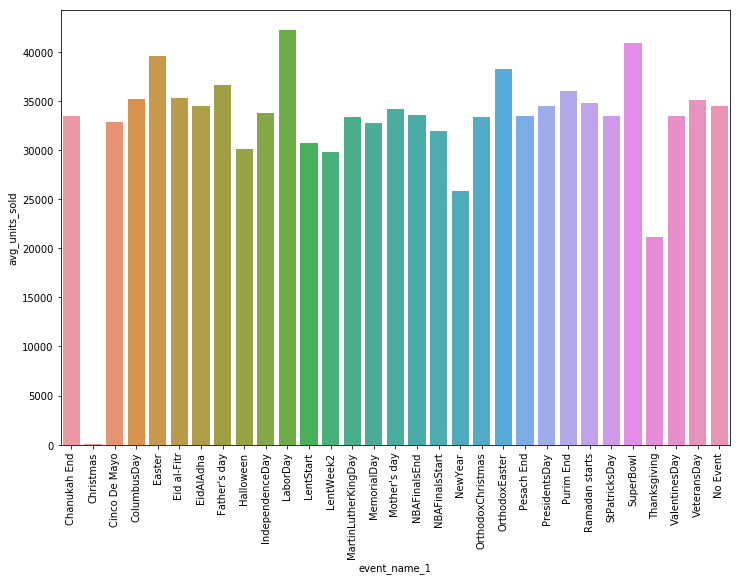

In [40]:
figure = plt.figure(figsize=(12,8))
ax = sns.barplot(x="event_name_1", y="avg_units_sold", data=avg_units_sold_event1_days)
for item in ax.get_xticklabels():
    item.set_rotation(90)

We notice that, for event_name_1, Christmas has almost no sale, Thanksgiving has low sale, and Labour Day has the highest sale.

In [41]:
# avg daily units sold per event
avg_units_sold_event2_days = df[~df.event_name_2.isnull()] \
                            [['event_name_2', 'day_number', 'units_sold']] \
                            .groupby('event_name_2') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()


# rename columns
avg_units_sold_event2_days.columns = ['event_name_2', 'avg_units_sold']

row_df = pd.DataFrame({'event_name_2':'No Event', 'avg_units_sold': [no_event_daily_avg_units]})
avg_units_sold_event2_days = pd.concat([avg_units_sold_event2_days, row_df], ignore_index=True)

avg_units_sold_event2_days

,event_name_2,avg_units_sold
0,Cinco De Mayo,43203.000000
1,Easter,24018.000000
2,Father's day,42494.000000
3,OrthodoxEaster,38934.000000
4,No Event,34489.207504


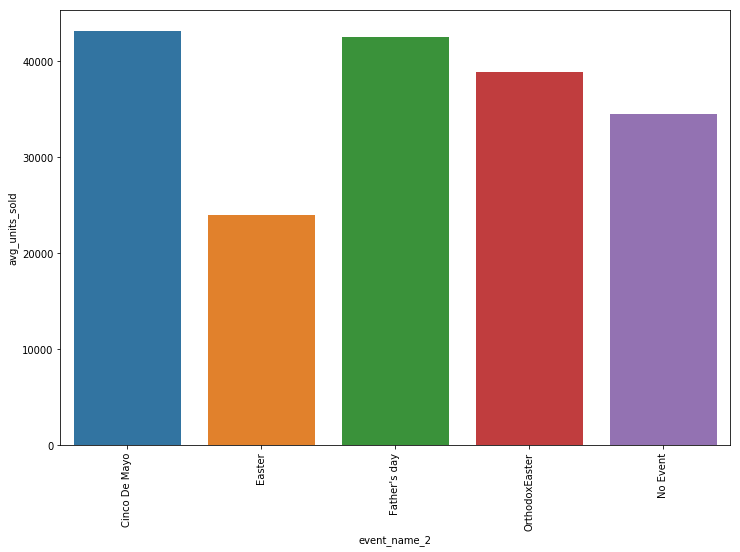

In [42]:
figure = plt.figure(figsize=(12,8))
ax = sns.barplot(x="event_name_2", y="avg_units_sold", data=avg_units_sold_event2_days)
for item in ax.get_xticklabels():
    item.set_rotation(90)

We notice that, for event_name_2, Easter has lower sales compared to the others.

In [43]:
# avg daily units sold per dept
avg_dept_sales_days = df[['dept_id', 'day_number', 'units_sold']] \
                            .groupby('dept_id') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()

# rename columns
avg_dept_sales_days.columns = ['dept_id', 'avg_units_sold']

avg_dept_sales_days

,dept_id,avg_units_sold
0,FOODS_1,2659.718244
1,FOODS_2,3988.406691
2,FOODS_3,16922.151594
3,HOBBIES_1,2925.488761
4,HOBBIES_2,276.184004
5,HOUSEHOLD_1,6011.775222
6,HOUSEHOLD_2,1557.837951


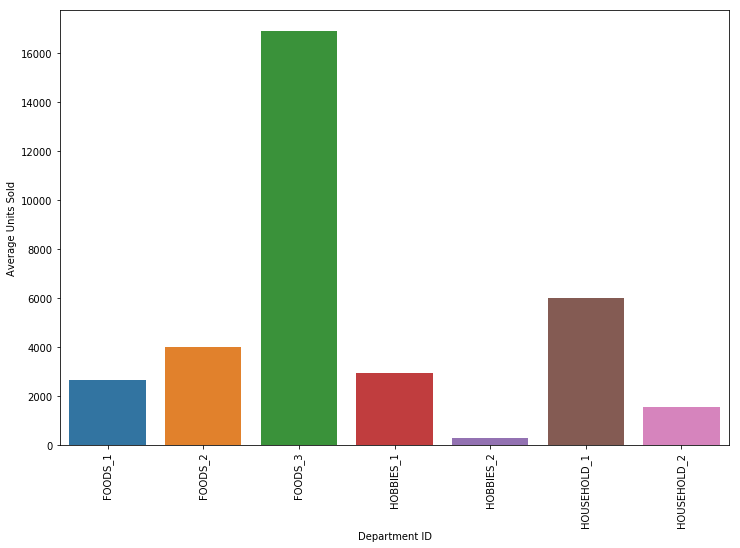

In [44]:
figure = plt.figure(figsize=(12,8))
ax = sns.barplot(x="dept_id", y="avg_units_sold", data=avg_dept_sales_days)
ax.set(xlabel="Department ID", ylabel = "Average Units Sold")
for item in ax.get_xticklabels():
    item.set_rotation(90)

We find that Foods_3 sells the most, while Hobbies_2 sells the least

In [45]:
# avg daily units sold per store
avg_store_sales_days = df[['store_id', 'day_number', 'units_sold']] \
                            .groupby('store_id') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()


# rename columns
avg_store_sales_days.columns = ['store_id', 'avg_units_sold']

avg_store_sales_days

,store_id,avg_units_sold
0,CA_1,4024.158913
1,CA_2,2972.020387
2,CA_3,5848.499739
3,CA_4,2145.152117
4,TX_1,2924.878202
5,TX_2,3771.240983
6,TX_3,3183.131208
7,WI_1,2691.616309
8,WI_2,3420.811291
9,WI_3,3360.053319


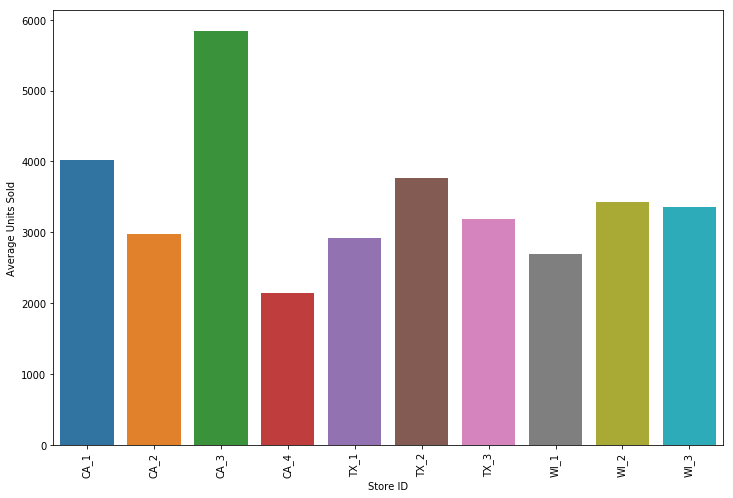

In [46]:
figure = plt.figure(figsize=(12,8))
ax = sns.barplot(x="store_id", y="avg_units_sold", data=avg_store_sales_days)
ax.set(xlabel="Store ID", ylabel = "Average Units Sold")
for item in ax.get_xticklabels():
    item.set_rotation(90)

We find that most stores have similar daily sales, except CA_3, which sells more than usual

In [47]:
# avg daily units sold per day of the week
avg_weekday_sales_days = df[['weekday', 'day_number', 'units_sold']] \
                            .groupby('weekday') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()


# rename columns
avg_weekday_sales_days.columns = ['weekday', 'avg_units_sold']

avg_weekday_sales_days

,weekday,avg_units_sold
0,Friday,34225.985348
1,Monday,32852.967033
2,Saturday,41546.894161
3,Sunday,41130.021898
4,Thursday,30205.007326
5,Tuesday,30368.780220
6,Wednesday,30010.021978


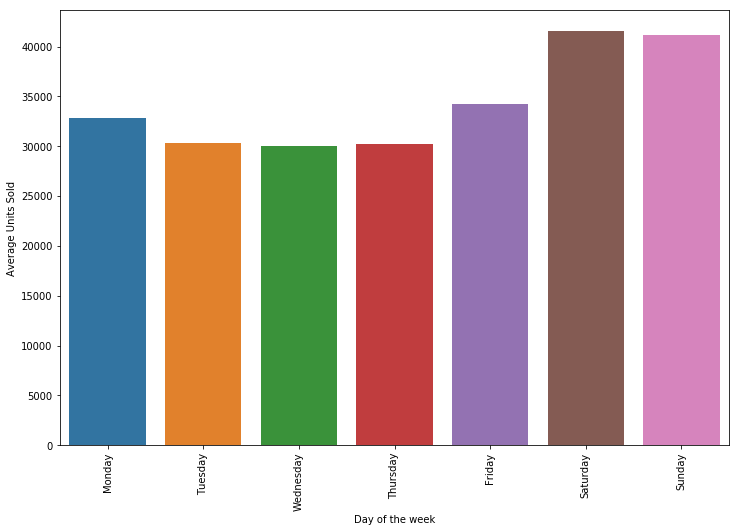

In [48]:
figure = plt.figure(figsize=(12,8))
ax = sns.barplot(x="weekday", y="avg_units_sold", data=avg_weekday_sales_days, 
                 order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.set(xlabel="Day of the week", ylabel = "Average Units Sold")
for item in ax.get_xticklabels():
    item.set_rotation(90)

We find that on average, there's more sale during the weekends than during weekdays

In [49]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,weekday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4


In [50]:
# avg daily units sold acc. to snap values
avg_snapTX_sales_days = df[['snap_TX', 'day_number', 'units_sold']] \
                            .groupby('snap_TX') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()
avg_snapTX_sales_days.columns = ['snap', 'avg_units_sold']
avg_snapTX_sales_days['snap'] = avg_snapTX_sales_days['snap'] \
                            .apply(lambda x: 'snap_TX_no' if x==0 else 'snap_TX_yes')

avg_snapCA_sales_days = df[['snap_CA', 'day_number', 'units_sold']] \
                            .groupby('snap_CA') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()
avg_snapCA_sales_days.columns = ['snap', 'avg_units_sold']
avg_snapCA_sales_days['snap'] = avg_snapCA_sales_days['snap'] \
                            .apply(lambda x: 'snap_CA_no' if x==0 else 'snap_CA_yes')


avg_snapWI_sales_days = df[['snap_WI', 'day_number', 'units_sold']] \
                            .groupby('snap_WI') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()
avg_snapWI_sales_days.columns = ['snap', 'avg_units_sold']
avg_snapWI_sales_days['snap'] = avg_snapWI_sales_days['snap'] \
                            .apply(lambda x: 'snap_WI_no' if x==0 else 'snap_WI_yes')


avg_snapTX_sales_days

,snap,avg_units_sold
0,snap_TX_no,33263.012471
1,snap_TX_yes,36538.038095


In [51]:
merge1 = pd.concat([avg_snapTX_sales_days, avg_snapCA_sales_days])
merge2 = pd.concat([merge1, avg_snapWI_sales_days])
merge2

,snap,avg_units_sold
0,snap_TX_no,33263.012471
1,snap_TX_yes,36538.038095
0,snap_CA_no,33408.506625
1,snap_CA_yes,36241.738095
0,snap_WI_no,33239.736555
1,snap_WI_yes,36585.439683


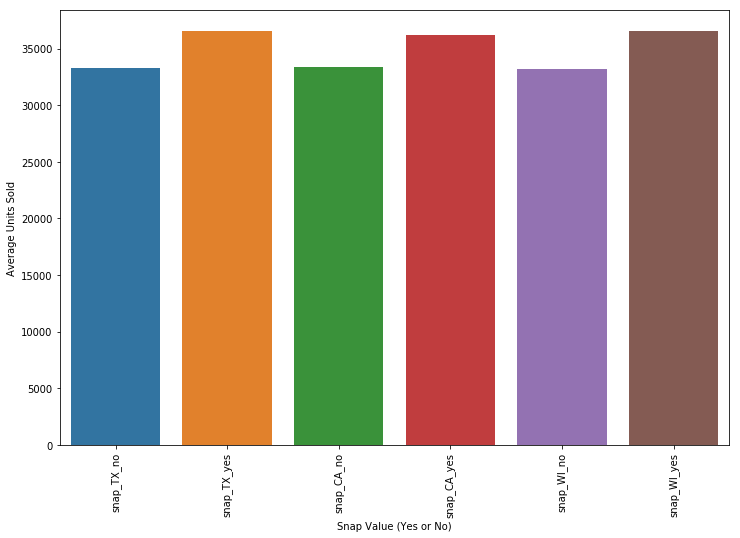

In [52]:
figure = plt.figure(figsize=(12,8))
ax = sns.barplot(x="snap", y="avg_units_sold", data=merge2)
ax.set(xlabel="Snap Value (Yes or No)", ylabel = "Average Units Sold")
for item in ax.get_xticklabels():
    item.set_rotation(90)

We find that average sales over all products increases only slightly if snap values occur

In [53]:
df['day_number'] = df['day_number'].astype('int16') 
# because day_number is currently category and plot is erroring out if it's category

In [54]:
df.dtypes

id                    category
item_id               category
dept_id               category
cat_id                category
store_id              category
state_id              category
day_number               int16
units_sold               int16
date            datetime64[ns]
weekday               category
month                     int8
year                     int16
event_name_1          category
event_type_1          category
event_name_2          category
event_type_2          category
snap_CA                   int8
snap_TX                   int8
snap_WI                   int8
sell_price             float16
week                     int64
dtype: object

In [55]:
# rolling mean of total daily units sold per day for 1913 days 
total_daily_sales = df[['day_number', 'units_sold']].groupby('day_number').sum().reset_index()

# rename columns
total_daily_sales.columns = ['day', 'total_units_sold']
total_daily_sales['total_units_sold_rolling_mean'] = total_daily_sales['total_units_sold'] \
                                .rolling(50, min_periods=1).mean()
total_daily_sales

,day,total_units_sold,total_units_sold_rolling_mean
0,1,32631.0,32631.000000
1,2,31749.0,32190.000000
2,3,23783.0,29387.666667
3,4,25412.0,28393.750000
4,5,19146.0,26544.200000
5,6,29211.0,26988.666667
6,7,28010.0,27134.571429
7,8,37932.0,28484.250000
8,9,32736.0,28956.666667
9,10,25572.0,28618.200000


In [56]:
total_daily_sales.dtypes

day                                int64
total_units_sold                 float64
total_units_sold_rolling_mean    float64
dtype: object

Text(0, 0.5, 'Rolling mean of units sold')

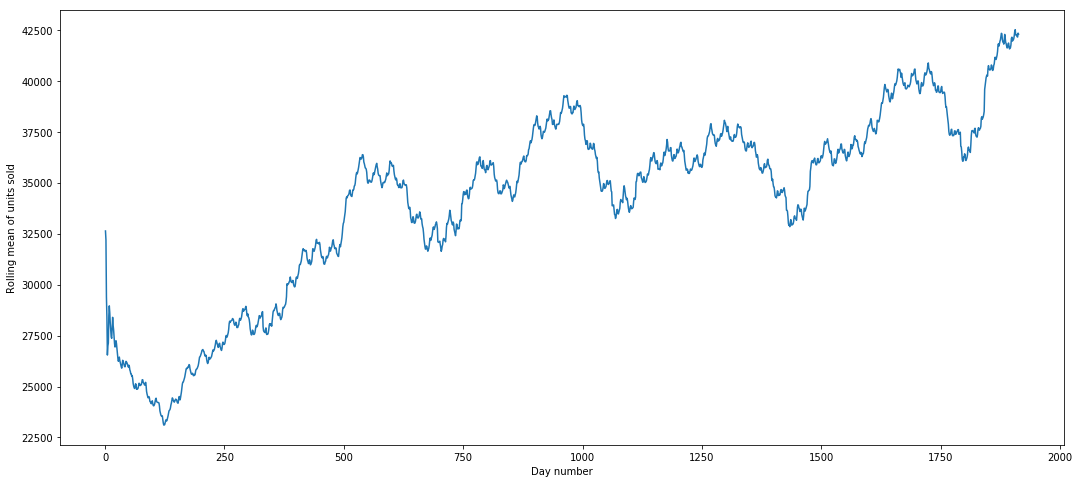

In [57]:
figure = plt.figure(figsize=(18,8))
plt.plot(total_daily_sales.iloc[:, 0], total_daily_sales.iloc[:,2])
plt.xlabel('Day number')
plt.ylabel('Rolling mean of units sold')

We notice that some date ranges have clear upward and downward trends in average units sold. To investigate further, we can plot date on the x axis.

In [58]:
total_daily_sales_date = df[['date', 'units_sold']].groupby('date').sum().reset_index()

# rename columns
total_daily_sales_date.columns = ['date', 'total_units_sold']
total_daily_sales_date['total_units_sold_rolling_mean'] = total_daily_sales['total_units_sold'] \
                                .rolling(50, min_periods=1).mean()
total_daily_sales_date

,date,total_units_sold,total_units_sold_rolling_mean
0,2011-01-29,32631.0,32631.000000
1,2011-01-30,31749.0,32190.000000
2,2011-01-31,23783.0,29387.666667
3,2011-02-01,25412.0,28393.750000
4,2011-02-02,19146.0,26544.200000
5,2011-02-03,29211.0,26988.666667
6,2011-02-04,28010.0,27134.571429
7,2011-02-05,37932.0,28484.250000
8,2011-02-06,32736.0,28956.666667
9,2011-02-07,25572.0,28618.200000


/home/asif/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Rolling mean of units sold')

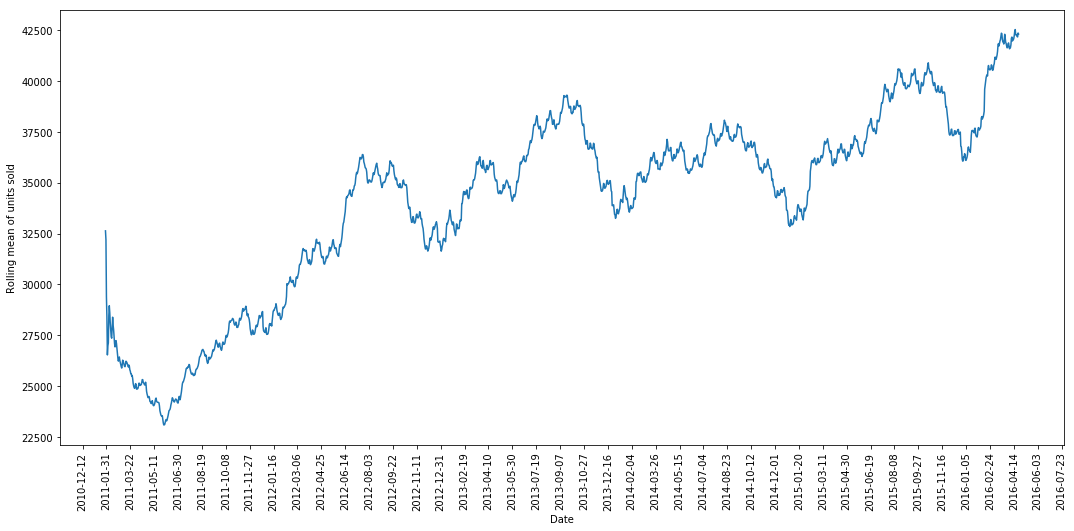

In [59]:
figure = plt.figure(figsize=(18,8))
ax = plt.subplot(1,1,1)
plt.plot(total_daily_sales_date.iloc[:, 0], total_daily_sales_date.iloc[:,2])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=50))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Rolling mean of units sold')

In general, we can see that there is a spike in sales around September-October-November (Fall) and fall in sales around end of December/beginning of January (beginning/end of the year)

Next, we see information about the top 10 products that had the largest amount of unit sales in a day:

In [60]:
top_10_highest_selling_products_inaday = df[['item_id', 'units_sold']].groupby('item_id').max().reset_index()\
                    .sort_values(by=['units_sold'], ascending=False)[:10]
top_10_highest_selling_products_inaday.columns = ['item_id', 'units_sold']
top_10_highest_selling_products_inaday

,item_id,units_sold
702,FOODS_3_090,763
1394,FOODS_3_785,648
499,FOODS_2_285,634
2466,HOUSEHOLD_1_474,626
2595,HOUSEHOLD_2_062,601
930,FOODS_3_318,436
1159,FOODS_3_547,385
1247,FOODS_3_635,355
1192,FOODS_3_580,349
682,FOODS_3_070,345


In [61]:
top_10_highest_selling_products_inaday = pd.merge(df, top_10_highest_selling_products_inaday, how='inner',
                                                  left_on='units_sold', right_on='units_sold')
top_10_highest_selling_products_inaday.sort_values(by=['units_sold'], ascending=False)

,id,item_id_x,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,weekday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week,item_id_y
10,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,960,763,2013-09-14,Saturday,9,2013,NaN,NaN,NaN,NaN,0,0,1,1.000000,37,FOODS_3_090
6,FOODS_3_785_CA_1_validation,FOODS_3_785,FOODS_3,FOODS,CA_1,CA,511,648,2012-06-22,Friday,6,2012,NaN,NaN,NaN,NaN,0,0,0,3.339844,25,FOODS_3_785
3,FOODS_2_285_TX_1_validation,FOODS_2_285,FOODS_2,FOODS,TX_1,TX,98,634,2011-05-06,Friday,5,2011,NaN,NaN,NaN,NaN,1,1,1,2.359375,18,FOODS_2_285
9,HOUSEHOLD_1_474_TX_2_validation,HOUSEHOLD_1_474,HOUSEHOLD_1,HOUSEHOLD,TX_2,TX,908,626,2013-07-24,Wednesday,7,2013,NaN,NaN,NaN,NaN,0,0,0,0.970215,30,HOUSEHOLD_1_474
7,HOUSEHOLD_2_062_TX_1_validation,HOUSEHOLD_2_062,HOUSEHOLD_2,HOUSEHOLD,TX_1,TX,859,601,2013-06-05,Wednesday,6,2013,NaN,NaN,NaN,NaN,1,1,1,2.939453,23,HOUSEHOLD_2_062
0,FOODS_3_318_CA_3_validation,FOODS_3_318,FOODS_3,FOODS,CA_3,CA,2,436,2011-01-30,Sunday,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.000000,4,FOODS_3_318
1,FOODS_3_318_CA_3_validation,FOODS_3_318,FOODS_3,FOODS,CA_3,CA,9,385,2011-02-06,Sunday,2,2011,SuperBowl,Sporting,NaN,NaN,1,1,1,1.000000,5,FOODS_3_547
2,FOODS_3_547_TX_3_validation,FOODS_3_547,FOODS_3,FOODS,TX_3,TX,928,385,2013-08-13,Tuesday,8,2013,NaN,NaN,NaN,NaN,0,1,0,0.080017,33,FOODS_3_547
8,FOODS_3_635_CA_3_validation,FOODS_3_635,FOODS_3,FOODS,CA_3,CA,883,355,2013-06-29,Saturday,6,2013,NaN,NaN,NaN,NaN,0,0,0,1.000000,26,FOODS_3_635
4,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,380,349,2012-02-12,Sunday,2,2012,NaN,NaN,NaN,NaN,0,1,1,1.280273,6,FOODS_3_580


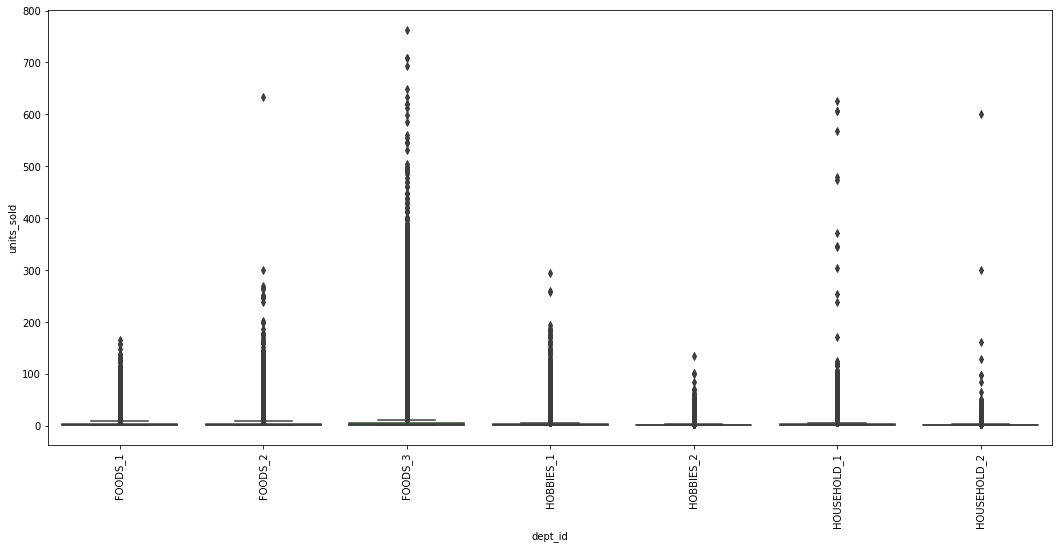

In [62]:
figure = plt.figure(figsize=(18,8))
ax = sns.boxplot(x="dept_id", y="units_sold", data=df[df.units_sold != 0])
for item in ax.get_xticklabels():
    item.set_rotation(90)

# PCA and K-means clustering

In [65]:
d_colnames
daily_sales_per_product = sales_train_validation_data[['item_id']+ d_colnames] \
                    .groupby('item_id').sum().reset_index()
daily_sales_per_product.head()

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,...,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1_001,6,6,4,6,7,18,10,4,11,10,6,5,12,15.0,16,18,11.0,10.0,12.0,7.0,17.0,9,9.0,8.0,5,14.0,26.0,8.0,12.0,13,5.0,11.0,10.0,14.0,11.0,8,22,14.0,6.0,9.0,13.0,5.0,10,10,7.0,5.0,6.0,12.0,12.0,...,6,9.0,3.0,1.0,9.0,5,2,4,11,4.0,3.0,6.0,3.0,10,12,6.0,2.0,6.0,3.0,9,18,4,5.0,2.0,3.0,5,5,2,3.0,6.0,4.0,10.0,1,5.0,4,6.0,8.0,0.0,6.0,3,4,4,30,7.0,5.0,3.0,6.0,2,16,6
1,FOODS_1_002,4,5,7,4,3,4,1,7,2,4,4,3,1,5.0,8,5,1.0,3.0,2.0,0.0,4.0,5,4.0,2.0,2,4.0,3.0,5.0,7.0,3,3.0,4.0,7.0,7.0,3.0,4,11,0.0,1.0,1.0,3.0,9.0,9,4,4.0,3.0,3.0,3.0,5.0,...,5,2.0,2.0,2.0,4.0,2,5,2,3,7.0,4.0,2.0,6.0,4,5,4.0,3.0,3.0,2.0,5,7,4,6.0,5.0,0.0,2,7,1,3.0,2.0,4.0,10.0,0,7.0,3,2.0,3.0,5.0,5.0,4,5,9,4,1.0,3.0,5.0,5.0,3,3,1
2,FOODS_1_003,14,8,3,6,3,8,13,10,11,6,11,10,3,17.0,20,14,10.0,9.0,3.0,14.0,7.0,23,16.0,7.0,12,6.0,5.0,7.0,10.0,6,10.0,6.0,8.0,3.0,9.0,18,18,11.0,8.0,4.0,12.0,15.0,24,6,6.0,8.0,8.0,7.0,11.0,...,9,0.0,6.0,5.0,3.0,12,7,8,6,2.0,8.0,6.0,4.0,8,6,5.0,8.0,6.0,7.0,5,7,6,6.0,10.0,8.0,5,6,2,7.0,3.0,2.0,4.0,4,5.0,8,7.0,7.0,4.0,4.0,1,7,3,5,6.0,3.0,4.0,4.0,3,11,5
3,FOODS_1_004,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0
4,FOODS_1_005,34,32,13,20,10,21,18,20,25,41,16,23,30,21.0,45,61,27.0,20.0,13.0,13.0,17.0,26,30.0,34.0,14,36.0,25.0,9.0,37.0,39,18.0,13.0,18.0,19.0,17.0,24,40,16.0,15.0,7.0,12.0,23.0,19,23,10.0,22.0,13.0,17.0,26.0,...,21,12.0,14.0,30.0,15.0,23,30,19,10,27.0,17.0,17.0,18.0,10,22,19.0,17.0,12.0,31.0,37,45,27,13.0,5.0,9.0,28,42,17,15.0,28.0,11.0,16.0,14,22.0,28,19.0,24.0,30.0,25.0,24,16,14,14,18.0,18.0,27.0,12.0,15,38,9


In [66]:
pca = PCA(n_components=50)
pca.fit(daily_sales_per_product.iloc[:,1:])
print(pca.explained_variance_ratio_)

[7.28320032e-01 5.40816086e-02 4.64182803e-02 2.08305817e-02
 1.28114538e-02 1.09144756e-02 9.72718611e-03 6.56735841e-03
 5.90812213e-03 4.83414244e-03 4.45096636e-03 4.25183246e-03
 3.72016272e-03 3.10484216e-03 2.78002846e-03 2.70357257e-03
 2.49542601e-03 2.28056719e-03 2.01463073e-03 1.87918262e-03
 1.84773969e-03 1.69938160e-03 1.55546473e-03 1.45429076e-03
 1.39368376e-03 1.26434324e-03 1.19232729e-03 1.14002378e-03
 1.10812627e-03 1.08680314e-03 1.02009044e-03 9.81220405e-04
 9.28429433e-04 8.54957561e-04 8.23627341e-04 8.13462234e-04
 8.00943976e-04 7.62738252e-04 7.32073849e-04 7.08959765e-04
 6.72886818e-04 6.42180099e-04 6.34014193e-04 6.08243632e-04
 5.95136886e-04 5.84277522e-04 5.55411410e-04 5.50506463e-04
 5.36571751e-04 5.09597941e-04]


In [67]:
pca_transformed_data = pca.transform(daily_sales_per_product.iloc[:,1:])
pca_transformed_data.shape

(3049, 50)

In [68]:
kmeans = KMeans(n_clusters=50, random_state=0).fit(pca_transformed_data)
kmeans.labels_.shape
daily_sales_per_product['cluster'] = kmeans.labels_

In [69]:
kmeans.inertia_

326202381.7731903

In [70]:
daily_sales_per_product[['item_id', 'cluster']]

,item_id,cluster
0,FOODS_1_001,2
1,FOODS_1_002,2
2,FOODS_1_003,2
3,FOODS_1_004,4
4,FOODS_1_005,6
5,FOODS_1_006,6
6,FOODS_1_008,47
7,FOODS_1_009,47
8,FOODS_1_010,47
9,FOODS_1_011,2


In [71]:
# See products within a particular cluster
daily_sales_per_product[daily_sales_per_product['cluster'] == 7]

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,...,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,cluster
1199,FOODS_3_587,298,353,234,310,205,214,190,572,508,428,370,328,356,374.0,426,491,338.0,351.0,246.0,275.0,281.0,393,477.0,389.0,328,290.0,293.0,351.0,417.0,458,320.0,335.0,293.0,313.0,357.0,360,422,293.0,279.0,220.0,233.0,247.0,283,424,337.0,240.0,222.0,220.0,268.0,...,224.0,202.0,207.0,198.0,199,217,383,299,262.0,312.0,246.0,241.0,314,319,289.0,290.0,228.0,193.0,258,287,303,222.0,255.0,188.0,182,209,271,344.0,235.0,217.0,220.0,221,257.0,303,333.0,294.0,190.0,224.0,243,254,242,308,247.0,214.0,190.0,168.0,242,277,305,7


Text(0.5, 1.0, 'Inertia of Cosine k-Means versus number of clusters')

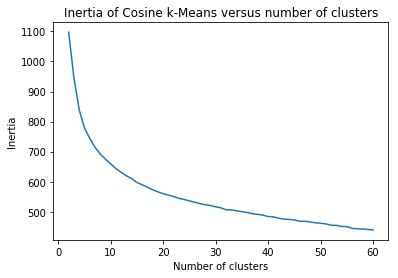

In [75]:
# Find optimum cluster with elbow method:
# https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb
normalized_vectors = preprocessing.normalize(pca_transformed_data)
scores = [KMeans(n_clusters=i).fit(normalized_vectors).inertia_  
          for i in range(2,61)]
sns.lineplot(np.arange(2, 61), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")

In [78]:
# Since elbow is around 10, we try with 10
kmeans = KMeans(n_clusters=10, random_state=0).fit(pca_transformed_data)
kmeans.labels_.shape
daily_sales_per_product['cluster'] = kmeans.labels_
print('Inertia: %s' %(kmeans.inertia_))
daily_sales_per_product[['item_id', 'cluster']]

Inertia: 833539568.4530507


,item_id,cluster
0,FOODS_1_001,0
1,FOODS_1_002,0
2,FOODS_1_003,0
3,FOODS_1_004,2
4,FOODS_1_005,7
5,FOODS_1_006,7
6,FOODS_1_008,0
7,FOODS_1_009,0
8,FOODS_1_010,0
9,FOODS_1_011,0


Text(0, 0.5, 'Count of cluster points')

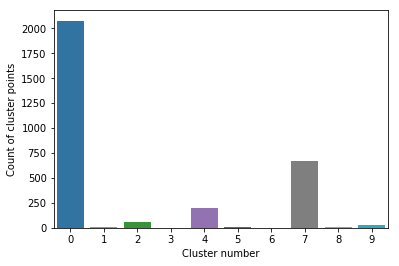

In [88]:
unique_clusters, counts_clusters = np.unique(kmeans.labels_, return_counts=True)
sns.barplot(unique_clusters, counts_clusters)
plt.xlabel('Cluster number')
plt.ylabel('Count of cluster points')

In [92]:
# Perform clustering on rolling values
daily_sales_per_product_rolling = daily_sales_per_product.copy()
daily_sales_per_product_rolling[d_colnames] = \
    daily_sales_per_product_rolling[d_colnames].apply(lambda x: x.rolling(window=50, min_periods=1).mean(), axis=1)

In [96]:
daily_sales_per_product_rolling.head()

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,...,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,cluster
0,FOODS_1_001,6.0,6.0,5.333333,5.50,5.8,7.833333,8.142857,7.625,8.000000,8.2,8.000000,7.750000,8.076923,8.571429,9.066667,9.6250,9.705882,9.722222,9.842105,9.70,10.047619,10.000000,9.956522,9.875000,9.68,9.846154,10.444444,10.357143,10.413793,10.500000,10.322581,10.34375,10.333333,10.441176,10.457143,10.388889,10.702703,10.789474,10.666667,10.625,10.682927,10.547619,10.534884,10.522727,10.444444,10.326087,10.234043,10.270833,10.306122,...,5.32,5.34,5.28,5.46,5.40,5.42,5.44,5.60,5.60,5.58,5.60,5.62,5.72,5.88,5.86,5.84,5.90,5.94,6.04,6.28,6.10,6.16,6.08,5.80,5.76,5.68,5.68,5.64,5.42,5.42,5.56,5.50,5.42,5.38,5.26,5.28,5.16,5.20,5.24,5.30,5.32,5.82,5.84,5.88,5.82,5.84,5.72,5.98,5.94,0
1,FOODS_1_002,4.0,4.5,5.333333,5.00,4.6,4.500000,4.000000,4.375,4.111111,4.1,4.090909,4.000000,3.769231,3.857143,4.133333,4.1875,4.000000,3.944444,3.842105,3.65,3.666667,3.727273,3.739130,3.666667,3.60,3.615385,3.592593,3.642857,3.758621,3.733333,3.709677,3.71875,3.818182,3.911765,3.885714,3.888889,4.081081,3.973684,3.897436,3.825,3.804878,3.928571,4.046512,4.045455,4.044444,4.021739,4.000000,3.979167,4.000000,...,4.16,4.10,4.06,4.08,4.10,4.10,4.02,4.08,4.18,4.18,4.12,4.22,4.28,4.28,4.30,4.22,4.22,4.10,3.98,4.02,4.00,4.06,4.08,4.04,4.00,4.08,3.98,3.92,3.90,3.86,4.04,4.00,4.08,4.08,4.04,3.98,4.00,4.02,3.92,3.94,4.08,4.10,4.10,4.06,4.10,4.02,3.92,3.88,3.82,0
2,FOODS_1_003,14.0,11.0,8.333333,7.75,6.8,7.000000,7.857143,8.125,8.444444,8.2,8.454545,8.583333,8.153846,8.785714,9.533333,9.8125,9.823529,9.777778,9.421053,9.65,9.523810,10.136364,10.391304,10.250000,10.32,10.153846,9.962963,9.857143,9.862069,9.733333,9.741935,9.62500,9.575758,9.382353,9.371429,9.611111,9.837838,9.868421,9.820513,9.675,9.731707,9.857143,10.186047,10.090909,10.000000,9.956522,9.914894,9.854167,9.877551,...,5.48,5.56,5.56,5.58,5.62,5.68,5.76,5.74,5.58,5.62,5.72,5.76,5.78,5.70,5.52,5.62,5.66,5.68,5.72,5.84,5.82,5.84,6.00,6.06,6.14,6.14,6.06,6.00,6.04,5.94,5.90,5.86,5.92,6.00,6.04,6.08,6.04,6.02,5.92,5.98,6.00,5.98,5.96,5.92,5.88,5.78,5.76,5.78,5.56,0
3,FOODS_1_004,0.0,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,28.40,27.38,26.06,24.72,23.46,22.00,19.96,18.52,17.24,15.98,14.72,13.24,11.40,10.18,9.10,7.56,5.68,4.30,3.14,1.92,1.18,0.34,0.14,0.12,0.12,0.12,0.12,0.12,0.12,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.04,0.04,0.00,0.00,0.00,0.00,2
4,FOODS_1_005,34.0,33.0,26.333333,24.75,21.8,21.666667,21.142857,21.000,21.444444,23.4,22.727273,22.750000,23.307692,23.142857,24.600000,26.8750,26.882353,26.500000,25.789474,25.15,24.761905,24.818182,25.043478,25.416667,24.96,25.384615,25.370370,24.785714,25.206897,25.666667,25.419355,25.03125,24.818182,24.647059,24.428571,24.416667,24.837838,24.605263,24.358974,23.925,23.634146,23.619048,23.511628,23.500000,23.200000,23.173913,22.957447,22.833333,22.897959,...,18.46,18.42,18.72,18.86,18.94,19.26,19.32,19.14,19.50,19.56,19.52,19.76,19.74,19.64,19.50,19.64,19.44,19.72,19.84,20.48,20.64,20.40,20.34,20.30,20.50,20.60,20.26,19.68,19.90,19.74,19.82,19.68,19.92,19.90,19.76,19.76,19.90,20

In [107]:
def pca_and_kmeans(df, state=None):
    day_start_col_num = 1
    if state:
        df = df[df['state_id'] == state]
        day_start_col_num = 2
    pca = PCA(n_components=50)
    pca.fit(df.iloc[:,day_start_col_num:])
    print(pca.explained_variance_ratio_)
    pca_transformed_data = pca.transform(df.iloc[:,day_start_col_num:])

    normalized_vectors = preprocessing.normalize(pca_transformed_data)
    scores = [KMeans(n_clusters=i).fit(normalized_vectors).inertia_  
              for i in range(2,61)]
    sns.lineplot(np.arange(2, 61), scores)
    plt.xlabel('Number of clusters')
    plt.ylabel("Inertia")
    plt.title("Inertia of Cosine k-Means versus number of clusters")
    plt.show()
    # Since elbow is around 10, we try with 10
    kmeans = KMeans(n_clusters=10, random_state=0).fit(pca_transformed_data)
    print(kmeans.labels_.shape)
    df['cluster'] = kmeans.labels_
    print('Inertia: %s' %(kmeans.inertia_))
    print(df[['item_id', 'cluster']])

    unique_clusters, counts_clusters = np.unique(kmeans.labels_, return_counts=True)
    sns.barplot(unique_clusters, counts_clusters)
    plt.title('Products per cluster '+ state if state else '')
    plt.xlabel('Cluster number')
    plt.ylabel('Count of cluster points')

[8.10333129e-01 5.33858915e-02 4.07202966e-02 1.99829447e-02
 1.26161317e-02 1.20700021e-02 7.61973882e-03 6.69714264e-03
 4.76564516e-03 3.95514693e-03 3.67828078e-03 2.68780339e-03
 2.31085451e-03 2.21005483e-03 1.91792712e-03 1.57504918e-03
 1.51342342e-03 1.18493026e-03 1.17486756e-03 8.51137862e-04
 7.80492679e-04 7.35511300e-04 6.66222648e-04 6.20990109e-04
 5.42690826e-04 4.98044969e-04 4.64735640e-04 4.34682980e-04
 3.50699909e-04 3.05930268e-04 2.95870195e-04 2.62667007e-04
 2.57316560e-04 2.22410707e-04 2.06659645e-04 1.85654513e-04
 1.62578483e-04 1.49370345e-04 1.45556903e-04 1.29307001e-04
 1.14787158e-04 1.03259760e-04 1.02024622e-04 7.63044152e-05
 7.36775232e-05 7.03412234e-05 5.67315700e-05 5.23064340e-05
 4.95522879e-05 4.43422836e-05]


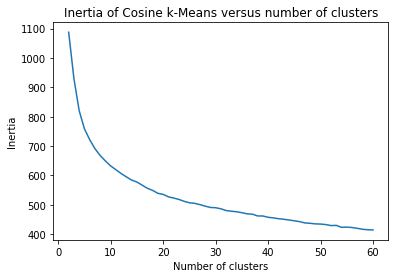

(3049,)
Inertia: 636728407.1239439
              item_id  cluster
0         FOODS_1_001        0
1         FOODS_1_002        0
2         FOODS_1_003        0
3         FOODS_1_004        6
4         FOODS_1_005        8
5         FOODS_1_006        8
6         FOODS_1_008        0
7         FOODS_1_009        0
8         FOODS_1_010        0
9         FOODS_1_011        0
10        FOODS_1_012        2
11        FOODS_1_013        8
12        FOODS_1_014        0
13        FOODS_1_015        0
14        FOODS_1_016        0
15        FOODS_1_017        0
16        FOODS_1_018        6
17        FOODS_1_019        2
18        FOODS_1_020        8
19        FOODS_1_021        8
20        FOODS_1_022        0
21        FOODS_1_023        8
22        FOODS_1_024        8
23        FOODS_1_025        0
24        FOODS_1_026        0
25        FOODS_1_027        8
26        FOODS_1_028        0
27        FOODS_1_029        0
28        FOODS_1_030        0
29        FOODS_1_031        8
... 

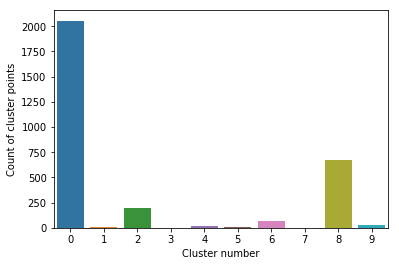

In [108]:
pca_and_kmeans(daily_sales_per_product_rolling)

In [101]:
# See products for 7, 3, 1
daily_sales_per_product_rolling[daily_sales_per_product_rolling['cluster'] == 7]

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,...,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,cluster
702,FOODS_3_090,1046.0,1041.0,918.333333,849.25,785.6,800.833333,846.0,904.125,948.777778,905.6,823.727273,755.083333,697.0,647.214286,604.066667,566.3125,533.0,503.388889,476.894737,453.05,431.47619,411.863636,393.956522,377.541667,362.44,348.5,335.592593,323.607143,312.448276,302.033333,292.290323,283.15625,274.575758,266.5,258.885714,251.694444,244.891892,238.447368,232.333333,226.525,221.0,215.738095,210.72093,205.931818,201.355556,196.978261,192.787234,188.770833,184.918367,...,532.2,532.5,532.82,535.46,539.54,545.14,543.4,540.94,540.48,542.44,544.38,546.42,549.42,547.74,542.68,542.76,543.8,543.78,549.92,558.02,560.78,551.08,550.92,552.52,553.36,556.12,559.4,556.56,551.7,550.0,549.68,548.4,553.62,557.02,556.32,550.08,548.64,549.76,551.48,555.84,557.72,557.46,554.12,553.46,552.44,550.66,554.1,558.04,555.58,7


In [102]:
daily_sales_per_product_rolling[daily_sales_per_product_rolling['cluster'] == 3]

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,...,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,cluster
1198,FOODS_3_586,516.0,497.5,441.0,424.75,403.6,408.0,407.571429,434.625,446.0,444.6,439.272727,435.25,430.153846,437.214286,455.6,471.6875,470.529412,470.055556,465.578947,462.25,463.52381,470.090909,474.173913,470.166667,468.72,465.961538,462.814815,463.714286,467.310345,470.666667,467.0,466.40625,464.878788,464.558824,465.8,470.027778,474.0,472.315789,471.25641,469.875,469.146341,469.095238,472.72093,474.613636,473.244444,472.73913,471.085106,470.854167,470.081633,...,403.44,403.16,404.28,405.84,407.2,410.26,410.7,409.4,410.42,412.02,413.88,415.2,416.82,416.72,414.24,413.42,414.22,414.38,417.96,423.38,424.62,422.12,420.86,419.74,418.42,416.16,415.78,413.18,409.72,408.82,408.5,409.8,411.9,414.08,413.28,410.26,409.66,408.96,409.96,410.08,412.24,411.94,409.92,411.42,411.02,410.68,409.78,411.64,411.48,3


In [103]:
daily_sales_per_product_rolling[daily_sales_per_product_rolling['cluster'] == 1]

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,...,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,cluster
931,FOODS_3_319,20.0,32.0,34.666667,34.5,30.2,29.500000,30.428571,35.500,36.666667,37.9,37.454545,36.916667,36.692308,36.500000,36.533333,36.8125,37.117647,37.500000,38.736842,39.00,38.571429,39.181818,39.608696,39.375000,38.88,38.346154,38.037037,38.178571,38.103448,38.633333,39.193548,38.93750,38.909091,38.264706,39.057143,39.305556,39.540541,39.657895,40.179487,39.875,40.292683,40.666667,41.116279,41.954545,41.888889,41.913043,41.936170,41.937500,41.816327,...,81.52,81.86,81.62,81.62,82.12,82.86,83.66,83.66,84.02,84.30,84.34,84.26,84.72,84.36,83.58,84.54,84.60,84.84,85.74,86.76,86.04,85.96,85.76,85.98,84.78,83.60,82.36,80.50,78.34,76.66,75.30,74.08,72.76,70.60,69.10,66.90,65.62,64.24,62.76,61.40,60.30,57.80,55.00,53.06,51.40,49.90,48.16,46.96,44.82,1
1153,FOODS_3_541,141.0,132.0,127.666667,114.5,109.6,103.333333,100.285714,99.875,106.000000,107.7,106.818182,103.250000,102.153846,101.357143,103.200000,104.3750,102.294118,101.555556,100.894737,100.05,99.714286,101.318182,103.608696,105.000000,110.84,109.692308,107.740741,106.107143,105.379310,104.466667,104.483871,103.43750,103.909091,103.882353,105.142857,105.805556,107.324324,108.052632,108.358974,108.950,108.512195,108.357143,109.813953,111.295455,112.333333,112.304348,112.382979,111.375000,111.163265,...,73.98,73.46,73.00,72.94,72.84,73.18,73.08,71.90,70.96,70.32,70.44,69.98,70.02,70.06,69.38,69.68,69.80,70.30,70.60,70.48,70.84,70.40,70.24,70.56,69.82,68.48,67.50,65.62,63.82,61.54,60.30,59.22,57.66,56.12,54.74,52.32,51.10,49.90,49.36,48.20,46.58,44.22,42.42,40.66,39.24,37.88,35.98,34.60,33.22,1
1247,FOODS_3_635,133.0,136.0,133.000000,114.5,104.6,100.000000,99.142857,101.625,106.111111,103.7,102.090909,98.333333,99.153846,98.857143,97.733333,99.9375,98.705882,97.777778,98.105263,99.40,99.285714,101.090909,102.652174,104.208333,104.00,103.692308,103.000000,101.928571,101.965517,104.733333,104.096774,104.12500,104.424242,104.529412,105.400000,106.250000,109.756757,109.552632,110.384615,110.650,110.560976,110.023810,110.465116,111.477273,111.711111,111.652174,111.787234,111.625000,111.204082,...,88.68,88.10,87.10,86.66,85.92,86.26,85.92,84.52,84.30,84.26,84.52,84.36,84.10,83.92,82.34,81.98,81.86,81.22,80.80,81.48,80.42,79.96,79.80,80.08,78.98,77.32,75.92,74.12,71.98,69.24,67.72,65.96,63.78,62.10,60.36,57.96,55.98,54.82,53.84,52.38,50.82,49.54,47.94,46.42,44.80,43.20,41.76,40.52,39.00,1
1417,FOODS_3_808,103.0,103.5,107.000000,99.5,91.6,88.500000,86.428571,85.750,89.888889,86.7,86.000000,81.500000,81.615385,79.571429,80.266667,83.0625,81.823529,82.555556,81.263158,80.15,79.285714,79.590909,81.173913,82.041667,82.08,82.230769,81.370370,81.107143,80.448276,80.500000,80.064516,80.34375,80.939394,80.794118,80.828571,81.472222,83.702703,84.105263,84.384615,84.200,84.487805,85.285714,86.744186,88.431818,88.466667,88.326087,88.489362,87.729167,87.122449,...,102.76,100.92,100.28,100.74,100.20,100.88,100.96,101.20,100.68,99.48,99.10,99.78,99.66,99.38,98.64,98.90,98.02,97.38,96.50,96.68,97.04,96.76,96.24,96.72,95.16,93.34,91.60,88.90,86.52,84.10,81.78,80.14,78.60,76.86,74.06,70.84,68.82,66.76,65.14,63.66,61.96,59.36,56.54,53.68,52.14,50.50,48.94,47.26,45.14,1


In [104]:
daily_sales_per_product_rolling[daily_sales_per_product_rolling['cluster'] == 5]

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,...,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,cluster
838,FOODS_3_226,210.0,189.0,165.666667,165.50,155.6,162.833333,166.857143,175.375,174.888889,174.7,166.363636,163.833333,164.076923,166.071429,170.533333,174.5625,176.117647,174.777778,173.315789,172.25,173.571429,174.500000,174.782609,173.583333,172.36,171.346154,170.407407,171.142857,171.310345,171.266667,170.516129,170.84375,170.818182,171.058824,171.171429,172.638889,173.297297,172.736842,172.333333,171.850,170.804878,170.928571,171.674419,172.068182,171.488889,171.282609,170.276596,169.833333,169.693878,...,188.88,189.60,190.28,191.20,192.60,194.56,195.10,195.68,197.24,198.68,200.60,201.50,202.36,202.98,202.48,201.70,201.16,201.26,202.48,204.54,205.00,203.96,204.06,203.60,202.10,200.44,200.40,200.34,197.90,197.42,197.20,197.20,197.30,197.44,197.12,196.96,197.12,197.82,198.14,197.84,198.62,198.42,197.88,197.38,197.08,196.60,196.88,196.46,195.34,5
864,FOODS_3_252,289.0,281.0,239.666667,222.75,204.6,206.833333,209.714286,228.875,231.777778,229.0,224.454545,221.000000,220.615385,223.142857,238.200000,250.1250,250.000000,250.555556,248.315789,246.30,246.857143,252.318182,254.826087,255.250000,253.52,251.423077,249.111111,249.357143,252.206897,255.000000,255.032258,255.25000,254.787879,254.058824,254.142857,256.527778,258.108108,256.394737,255.538462,254.525,253.317073,253.928571,256.627907,257.659091,257.088889,256.086957,256.106383,256.125000,255.938776,...,259.52,259.18,259.70,261.18,263.94,266.86,267.70,268.16,270.12,271.80,275.32,278.16,280.58,280.24,278.00,278.30,278.62,279.50,283.76,288.02,289.30,287.68,287.46,286.12,285.08,284.14,285.28,284.58,281.98,281.18,281.28,282.06,282.96,284.44,281.20,279.20,279.34,279.54,279.48,280.04,282.80,282.80,281.28,282.46,282.78,283.50,282.98,287.26,286.26,5
1167,FOODS_3_555,321.0,318.0,283.333333,263.50,242.6,246.333333,245.428571,267.875,277.555556,272.2,270.454545,263.750000,261.538462,266.071429,277.533333,284.4375,280.117647,277.611111,276.105263,275.70,279.095238,283.727273,284.826087,283.208333,281.52,279.192308,277.851852,278.357143,280.620690,284.000000,281.064516,281.31250,280.757576,280.558824,281.742857,285.055556,287.702703,285.947368,285.025641,285.200,285.024390,286.166667,289.372093,290.931818,290.266667,290.413043,290.510638,290.750000,291.448980,...,217.22,217.46,217.42,218.20,219.66,222.28,224.04,224.30,225.32,226.60,227.20,228.50,229.96,228.34,226.38,226.34,226.74,226.52,228.98,231.06,232.54,231.76,231.50,231.02,230.48,230.02,232.18,232.58,231.30,230.54,230.38,231.20,232.24,233.70,233.12,232.40,232.82,232.10,232.46,232.46,234.08,233.82,232.82,233.62,234.20,234.68,235.10,236.36,235.38,5
1199,FOODS_3_587,298.0,325.5,295.000000,298.75,280.0,269.000000,257.714286,297.000,320.444444,331.2,334.727273,334.166667,335.846154,338.571429,344.400000,353.5625,352.647059,352.555556,346.947368,343.35,340.380952,342.772727,348.608696,350.291667,349.40,347.115385,345.111111,345.321429,347.793103,351.466667,350.451613,349.96875,348.242424,347.205882,347.485714,347.833333,349.837838,348.342105,346.564103,343.400,340.707317,338.476190,337.186047,339.159091,339.111111,336.956522,334.510638,332.125000,330.816327,...,268.74,266.56,266.52,266.22,265.58,265.42,267.08,265.68,266.36,268.02,268.62,269.70,271.00,270.88,268.44,268.06,267.88,266.12,266.76,267.14,267.02,265.34,264.62,262.10,259.68,258.38,258.20,258.64,256.74,253.82,252.92,251.90,250.40,250.66,250.08,247.40,244.86,244.58,244.92,245.36,246.76,248.

In [ ]:
# See if you want to cluster by state (eg if the same item's sales trend is different in different states)

In [110]:
daily_sales_per_product_state = sales_train_validation_data[['item_id', 'state_id']+ d_colnames] \
                    .groupby(['item_id', 'state_id']).sum().reset_index()

[0.65938177 0.06165401 0.04987347 0.02529752 0.01351451 0.01312346
 0.0096406  0.00725015 0.00650242 0.00591747 0.00490914 0.0042961
 0.00418658 0.0038837  0.00344269 0.00312197 0.00302423 0.00260882
 0.00233227 0.00219526 0.00209458 0.0019615  0.00179524 0.0017525
 0.00168956 0.00161069 0.00159469 0.00151467 0.00145773 0.00143792
 0.00134754 0.001335   0.00127034 0.00123081 0.00117198 0.00114664
 0.0011213  0.00104704 0.00098258 0.00096503 0.0009372  0.00092602
 0.00091004 0.00086782 0.00085025 0.00083468 0.00081523 0.00079585
 0.00077111 0.00075251]


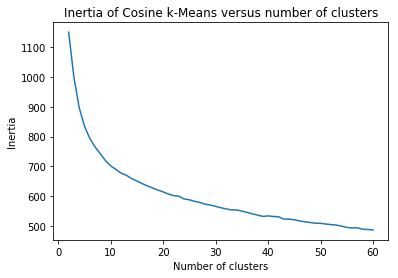

(3049,)
Inertia: 179885414.66228533
              item_id  cluster
0         FOODS_1_001        0
3         FOODS_1_002        0
6         FOODS_1_003        0
9         FOODS_1_004        3
12        FOODS_1_005        4
15        FOODS_1_006        4
18        FOODS_1_008        0
21        FOODS_1_009        0
24        FOODS_1_010        0
27        FOODS_1_011        0
30        FOODS_1_012        3
33        FOODS_1_013        4
36        FOODS_1_014        0
39        FOODS_1_015        0
42        FOODS_1_016        0
45        FOODS_1_017        0
48        FOODS_1_018        8
51        FOODS_1_019        3
54        FOODS_1_020        0
57        FOODS_1_021        4
60        FOODS_1_022        0
63        FOODS_1_023        4
66        FOODS_1_024        4
69        FOODS_1_025        0
72        FOODS_1_026        0
75        FOODS_1_027        4
78        FOODS_1_028        0
81        FOODS_1_029        0
84        FOODS_1_030        0
87        FOODS_1_031        4
...

/home/asif/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


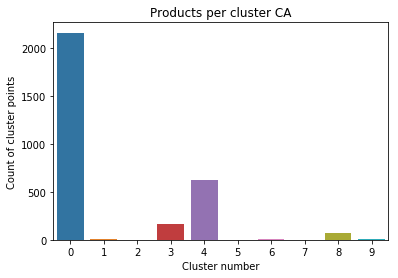

In [111]:
pca_and_kmeans(daily_sales_per_product_state, 'CA')

[0.61813761 0.04714017 0.0367166  0.02059821 0.01886001 0.01573054
 0.01205632 0.01122002 0.00952528 0.00780094 0.00740137 0.00668128
 0.00578518 0.00528594 0.00482536 0.00442603 0.00425382 0.00404214
 0.00388944 0.00364421 0.00347618 0.00340545 0.0031449  0.00309952
 0.00269152 0.0026133  0.00256047 0.00246631 0.00238941 0.00220595
 0.00215847 0.00202418 0.00198492 0.00194319 0.00180961 0.00171176
 0.00163879 0.00159914 0.00153045 0.00137146 0.00136453 0.00128549
 0.00125127 0.00122818 0.00117655 0.00112587 0.00111476 0.00107764
 0.00102423 0.00101711]


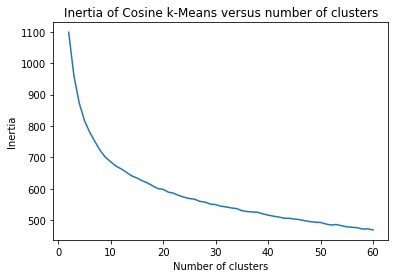

(3049,)
Inertia: 104485587.26958111
              item_id  cluster
2         FOODS_1_001        0
5         FOODS_1_002        0
8         FOODS_1_003        0
11        FOODS_1_004        3
14        FOODS_1_005        0
17        FOODS_1_006        8
20        FOODS_1_008        0
23        FOODS_1_009        0
26        FOODS_1_010        0
29        FOODS_1_011        0
32        FOODS_1_012        8
35        FOODS_1_013        0
38        FOODS_1_014        8
41        FOODS_1_015        0
44        FOODS_1_016        0
47        FOODS_1_017        0
50        FOODS_1_018        4
53        FOODS_1_019        2
56        FOODS_1_020        8
59        FOODS_1_021        8
62        FOODS_1_022        0
65        FOODS_1_023        0
68        FOODS_1_024        8
71        FOODS_1_025        0
74        FOODS_1_026        0
77        FOODS_1_027        8
80        FOODS_1_028        8
83        FOODS_1_029        0
86        FOODS_1_030        0
89        FOODS_1_031        0
...

/home/asif/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


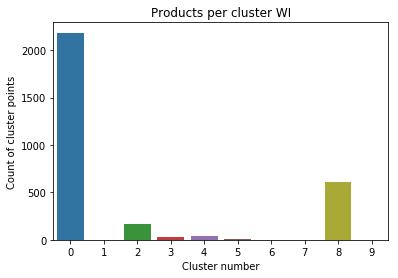

In [112]:
pca_and_kmeans(daily_sales_per_product_state, 'WI')

[7.10989053e-01 5.39008966e-02 3.72374645e-02 1.76475038e-02
 1.35962479e-02 1.15613900e-02 8.91480788e-03 6.09975612e-03
 4.70137676e-03 4.53538697e-03 4.20354971e-03 4.00090642e-03
 3.47895980e-03 3.27473803e-03 3.05295846e-03 2.77620837e-03
 2.56951126e-03 2.50701528e-03 2.35821194e-03 2.29986123e-03
 2.08479600e-03 1.91674734e-03 1.85098889e-03 1.80405749e-03
 1.70991819e-03 1.53414330e-03 1.45631979e-03 1.40138583e-03
 1.35957665e-03 1.33775154e-03 1.28750586e-03 1.17573124e-03
 1.13941624e-03 1.07625999e-03 1.04828368e-03 9.75722983e-04
 9.57789808e-04 9.21713131e-04 8.96903475e-04 8.87006987e-04
 8.61451875e-04 8.21075485e-04 7.99188975e-04 7.68336479e-04
 7.54113880e-04 7.23984491e-04 7.11332483e-04 7.05676024e-04
 6.73839512e-04 6.69993787e-04]


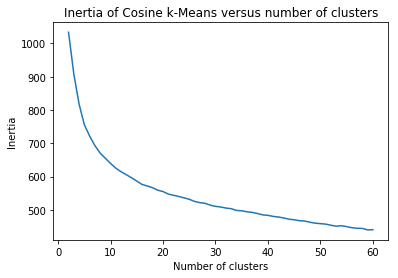

(3049,)
Inertia: 104326179.9573779
              item_id  cluster
1         FOODS_1_001        0
4         FOODS_1_002        0
7         FOODS_1_003        0
10        FOODS_1_004        5
13        FOODS_1_005        0
16        FOODS_1_006        0
19        FOODS_1_008        0
22        FOODS_1_009        0
25        FOODS_1_010        0
28        FOODS_1_011        0
31        FOODS_1_012        8
34        FOODS_1_013        0
37        FOODS_1_014        0
40        FOODS_1_015        0
43        FOODS_1_016        0
46        FOODS_1_017        0
49        FOODS_1_018        8
52        FOODS_1_019        2
55        FOODS_1_020        0
58        FOODS_1_021        0
61        FOODS_1_022        0
64        FOODS_1_023        2
67        FOODS_1_024        0
70        FOODS_1_025        0
73        FOODS_1_026        0
76        FOODS_1_027        2
79        FOODS_1_028        0
82        FOODS_1_029        0
85        FOODS_1_030        0
88        FOODS_1_031        0
... 

/home/asif/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


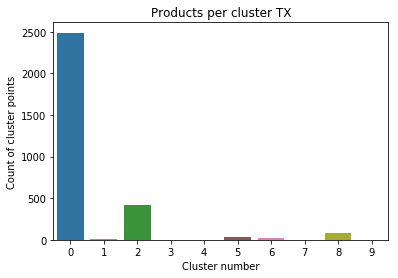

In [113]:
pca_and_kmeans(daily_sales_per_product_state, 'TX')

creation of training and target set → write down approach: how to create target variable (eg moving windows over time looking at previous sales), how to create training set, how will you divide data intro training, validation and test set (eg might want to do time-based split, should not have random split, explore what approaches people are following for time varying longitudinal split)